# Interpretation of Logistic Regression

In [193]:
# Import Necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, bernoulli, beta, norm
from scipy.special import expit as logistic_sigmoid
import statsmodels.api as sm
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

#### Load the NSDUH 2022 data, focus exclusively on smokers. Make a binary variable to indicate if a person is vaper or not, and set-up a few covariates. 

#### Get the data ready for fitting a logistic regression by dropping missing values and adding a constant for the intercept. 

In [194]:
# Load data

df = pd.read_stata('NSDUH_2022.dta')

# Keep only people who ever smoked a cigarette
df = df[df['cigever'] == '1 - Yes']

# Prepare variables
# Age
def age_sort(x):
    if x == '1 - 12-17 Years Old':
        return 1
    elif x == '2 - 18-25 Years Old':
        return 2
    elif x == '3 - 26-34 Years Old':
        return 3
    elif x == '4 - 35-49 Years Old':
        return 4
    elif x == '5 - 50-64 Years Old':
        return 5
    elif x == '4 - 65 or Older':
        return 6
    else:
        return 0
    
age = df['CATAG3'].apply(age_sort)
# print(age.value_counts())

# Military service
def military_sort(x):
    if x == '1 - Yes':
        return 1
    elif x == '2 - No':
        return 0
    else:
        return 0
    
military = df['service'].apply(military_sort)
# print(military.value_counts())

# Health
def health_sort(x):
    if x == '1 - Excellent':
        return 4
    elif x == '2 - Very Good':
        return 3
    elif x == '3 - Good':
        return 2
    elif x == '4 - Fair/Poor':
        return 1
    else:
        return 0
    
health = df['HEALTH2'].apply(health_sort)
# print(health.value_counts())

# Gender
def gender_sort(x):
    if x == '1 - Male':
        return 1
    elif x == '2 - Female':
        return 0
    
gender = df['irsex'].apply(gender_sort)
# print(gender.value_counts())

# Income
def income_sort(x):
    if x == '1 - Less than $10,000':
        return 1
    elif x == '2 - $10,000 - $19,999':
        return 2
    elif x == '3 - $20,000 - $29,999':
        return 3
    elif x == '4 - $30,000 - $39,999':
        return 4
    elif x == '5 - $40,000 - $49,999':
        return 5
    elif x == '6 - $50,000 - $74,999':
        return 6
    elif x == '7 - $75,000 or more':
        return 7
    else:
        return 0
income = df['IRPINC3'].apply(income_sort)
# print(income.value_counts())

# Employment
def employment_sort(x):
    if x == '1 - Yes':
        return 1
    elif x == '2 - No':
        return 0
    else:
        return 0
employment = df['wrkdpstwk'].apply(employment_sort)
# print(employment.value_counts())

vaper = df['nicvapever'].apply(lambda x: 1 if x == '1 - Yes' else 0)
# Create design matrix 
variables = pd.DataFrame({
    'Age': age,
    'Military': military,
    'Health' : health,
    'Gender' : gender,
    'Income' : income,
    'Employment' : employment,
    'Vaper' : vaper
})

variables = variables.dropna()

X = variables[['Age', 'Military', 'Health', 'Gender', 'Income', 'Employment']].astype(int)
Y= variables['Vaper'].astype(int)

X_with_intercept = sm.add_constant(X)

#### i) The `Homogeneous Probability` model:

#### Fit a logistic regression model with just an intercept, no other covariates. Plot the empirical posterior distribution of the baseline coefficients: a) on the log-odds scale; b) on the odds scale; c) on the probability scale. Interpret this result. 

In [195]:
# Fit the model 
model = sm.Logit(Y, X_with_intercept['const']).fit()

Optimization terminated successfully.
         Current function value: 0.693076
         Iterations 3


In [196]:
# Get summary results
summary = model.summary()
print(summary)

                           Logit Regression Results                           
Dep. Variable:                  Vaper   No. Observations:                24932
Model:                          Logit   Df Residuals:                    24931
Method:                           MLE   Df Model:                            0
Date:                Thu, 21 Mar 2024   Pseudo R-squ.:               1.751e-10
Time:                        16:57:40   Log-Likelihood:                -17280.
converged:                       True   LL-Null:                       -17280.
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0239      0.013     -1.887      0.059      -0.049       0.001


In [197]:
# Extract the coefficients (betas) and their covariance matrix from the logistic regression fit
beta_mean = model.params
beta_cov = model.cov_params()

In [198]:
# Number of simulations
n_simulations = 1000
# Simulate beta coefficients:

# on the log-odds scale
simulated_base_log_odds = multivariate_normal.rvs(mean=beta_mean, cov=beta_cov, size=n_simulations)

# on the odds scale
simulated_base_odds = np.exp(simulated_base_log_odds)

# on the probability scale
simulated_base_prob = logistic_sigmoid(simulated_base_log_odds)

# simulations array
simulated_base = np.stack((simulated_base_log_odds, simulated_base_odds, simulated_base_prob), axis=1)

In [199]:
print(simulated_base)

[[-0.03140734  0.96908074  0.49214881]
 [-0.035206    0.96540652  0.49119941]
 [-0.00215803  0.9978443   0.49946049]
 ...
 [-0.01926867  0.98091579  0.49518298]
 [-0.0270055   0.97335589  0.49324904]
 [-0.00726056  0.99276573  0.49818487]]


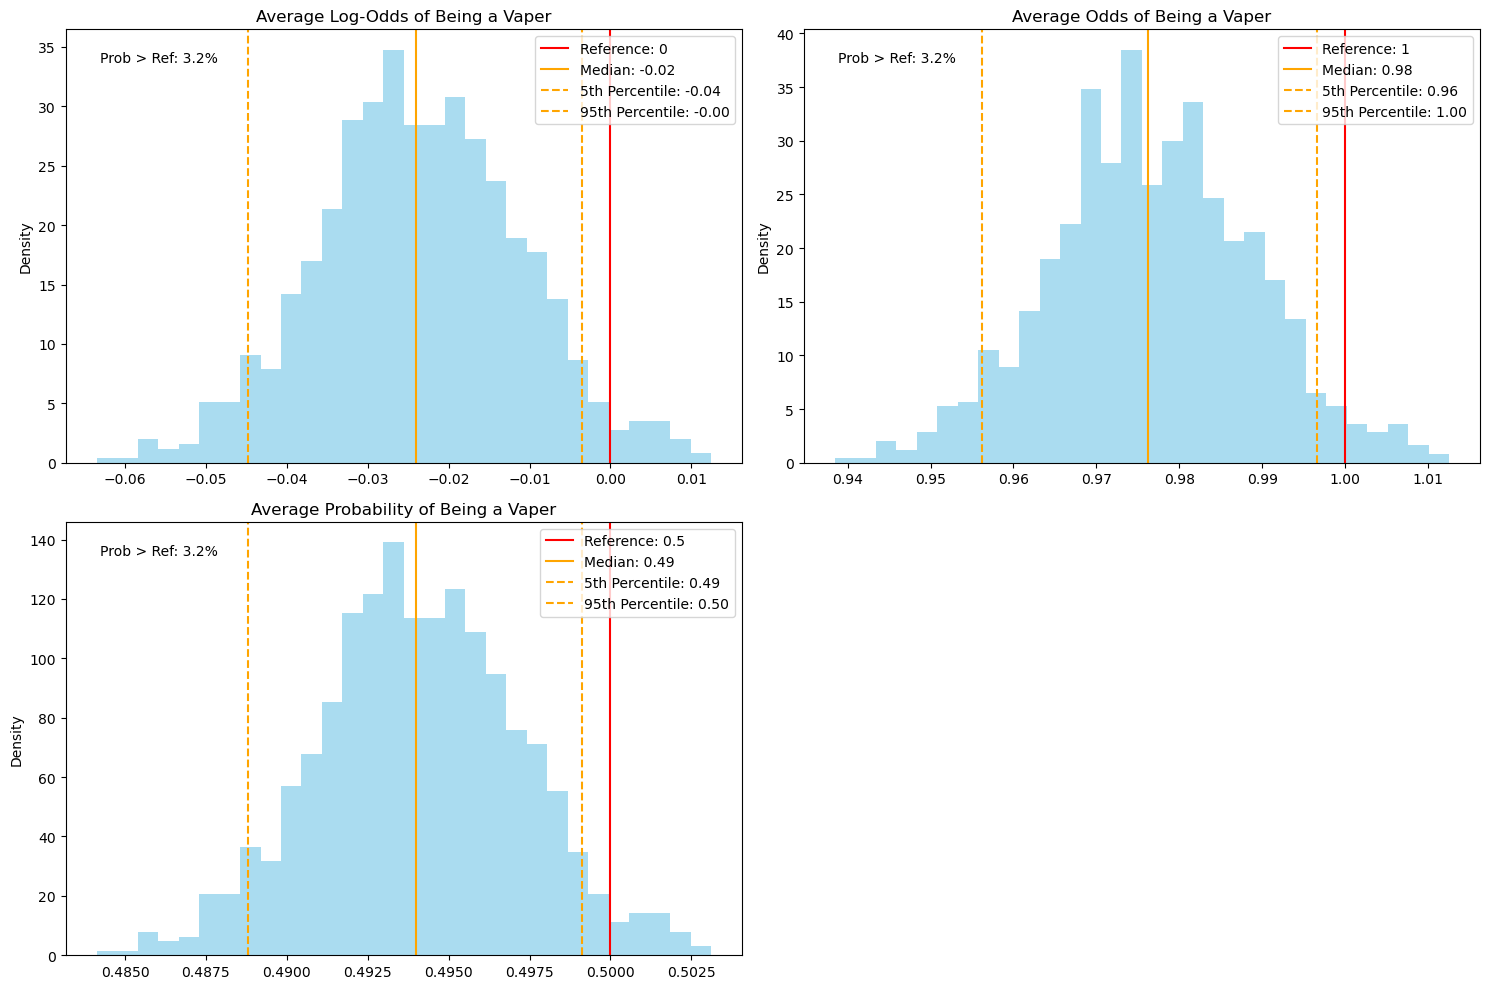

In [200]:
# Calculate statistics for each coefficient
medians = np.median(simulated_base, axis=0)
lower_quantiles = np.percentile(simulated_base, 5, axis=0)
upper_quantiles = np.percentile(simulated_base, 95, axis=0)
references = [0, 1, 0.5]  # Reference values for log-odds, odds, probability
prob_positive = [np.mean(simulated_base[:, i] > references[i]) for i in range(3)]

# Plot names 
col_names = ['Log-Odds', 'Odds', 'Probability']

# Plot histograms of each metric
fig, axs = plt.subplots(2, 2, figsize=(15, 10))  # Adjust for the number of metrics
axs = axs.flatten()

for i in range(len(col_names)):
    ax = axs[i]
    ax.hist(simulated_base[:, i], bins=30, density=True, alpha=0.7, color='skyblue')
    
    # Add vertical lines for reference, median, and 90% interval
    ax.axvline(references[i], color='red', linestyle='-', label=f'Reference: {references[i]}')
    ax.axvline(medians[i], color='orange', linestyle='-', label=f'Median: {medians[i]:.2f}')
    ax.axvline(lower_quantiles[i], color='orange', linestyle='--', label=f'5th Percentile: {lower_quantiles[i]:.2f}')
    ax.axvline(upper_quantiles[i], color='orange', linestyle='--', label=f'95th Percentile: {upper_quantiles[i]:.2f}')
    ax.text(0.05, 0.95, f'Prob > Ref: {prob_positive[i]*100:.1f}%', transform=ax.transAxes, verticalalignment='top')
    
    ax.set_title(f'Average {col_names[i]} of Being a Vaper')
    ax.set_ylabel('Density')
    ax.legend(loc='upper right')

# Hide empty subplot for uneven number of metrics
if len(col_names) % 2 != 0:
    axs[-1].axis('off')
    
plt.tight_layout()
plt.show()

#### Answer: 

...

#### ii) The `Heterogeneous Probability` model with one binary covariate: 

#### a) Let us build on the previous model. Firstly calculate the AIC (Akaike Information Criteria) of this homogeneous probability model - keep stock of this number, as we will use it to compare models in a few beats.

In [201]:
aic = model.aic
print("AIC:", aic)

AIC: 34561.52907839999


#### b) Now let us add some complexity to our model. We want to be able to model the fact that individuals have different propensity to decide vape e-cig or not based on some of their characteristics. Let us introduce the dummy `Gender` as a covariate, fit the model and plot posterior distribution of the coefficients, on the `odds` scale.

In [202]:
# Fit the model with college education
model = sm.Logit(Y, X_with_intercept[['const', 'Military']]).fit()

Optimization terminated successfully.
         Current function value: 0.688608
         Iterations 4


In [203]:
# Get summary results
summary = model.summary()
print(summary)

                           Logit Regression Results                           
Dep. Variable:                  Vaper   No. Observations:                24932
Model:                          Logit   Df Residuals:                    24930
Method:                           MLE   Df Model:                            1
Date:                Thu, 21 Mar 2024   Pseudo R-squ.:                0.006446
Time:                        16:57:41   Log-Likelihood:                -17168.
converged:                       True   LL-Null:                       -17280.
Covariance Type:            nonrobust   LLR p-value:                 2.265e-50
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0285      0.013      2.164      0.030       0.003       0.054
Military      -0.7507      0.052    -14.495      0.000      -0.852      -0.649


In [204]:
# Extract the coefficients (betas) and their covariance matrix from the logistic regression fit
beta_mean = model.params
beta_cov = model.cov_params()

In [205]:
# Simulate values of each regression coefficient from the posterior distirbution 

# Number of simulations
n_simulations = 1000

# Simulate beta coefficients
simulated_betas = multivariate_normal.rvs(mean=beta_mean, cov=beta_cov, size=n_simulations)

In [206]:
# Derive odds from log-odds coefficients 
simulated_betas_odds = np.exp(simulated_betas)

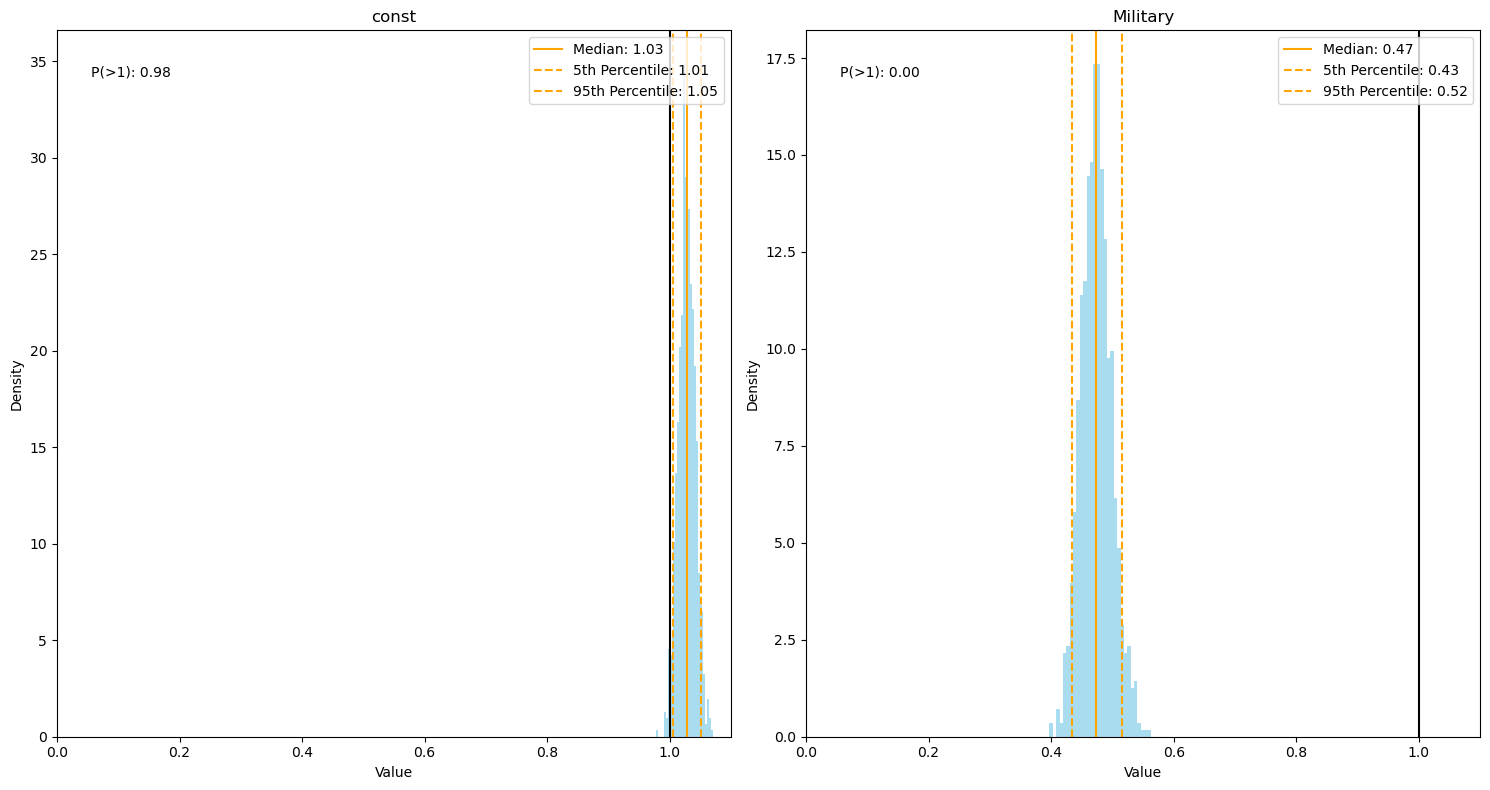

In [207]:
# Calculate statistics for each coefficient
medians = np.median(simulated_betas_odds, axis=0)
lower_quantiles = np.percentile(simulated_betas_odds, 5, axis=0)
upper_quantiles = np.percentile(simulated_betas_odds, 95, axis=0)
prob_positive = np.mean(simulated_betas_odds > 1, axis=0)

# Plot names 
col_names = ['const','Military']

# Plot histograms of each coefficient
num_rows = (simulated_betas.shape[1] + 1) // 2  # Adjusted number of rows
fig, axs = plt.subplots(num_rows, 2, figsize=(15, 8))
axs = axs.flatten()

for i in range(simulated_betas.shape[1]):
    ax = axs[i]
    ax.hist(simulated_betas_odds[:, i], bins=30, density=True, alpha=0.7, color='skyblue')

    # Add vertical lines for 0
    ax.axvline(1, color='black', linestyle='-')
    
    # Add vertical lines for median and 90% interval
    ax.axvline(medians[i], color='orange', linestyle='-', label=f'Median: {medians[i]:.2f}')
    ax.axvline(lower_quantiles[i], color='orange', linestyle='--', label=f'5th Percentile: {lower_quantiles[i]:.2f}')
    ax.axvline(upper_quantiles[i], color='orange', linestyle='--', label=f'95th Percentile: {upper_quantiles[i]:.2f}')
    
    # Add text annotation for probability above 1
    ax.text(0.05, 0.95, f'P(>1): {prob_positive[i]:.2f}', transform=ax.transAxes, verticalalignment='top', fontsize=10)
    
    ax.set_title(f'{ col_names[i]}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend(loc='upper right')

    # Set x-axis limit to ensure it includes 1 and starts at 0
    ax.set_xlim(left=0, right=max(1.1,abs(simulated_betas_odds[:, i]).max())) 
    
# Hide empty subplot
if simulated_betas.shape[1] % 2 != 0:
    axs[-1].axis('off')
    
plt.tight_layout()
plt.show()


#### c) Interpret the coefficients.

#### Answer: 

...

#### d) Get the AIC of this model, and comment on its value compared to the previous model. 

In [208]:
aic = model.aic
print("AIC:", aic)

AIC: 34340.77183086699


#### Answer: 

...

#### ii) The `Heterogeneous Probability` model with multiple covariates and interactions: 

#### a) Fit a logit model with Military, Gender, Age, Employment, and and interaction between Military and Employment

In [210]:
X_with_intercept['Military_Employment_Interaction'] = X['Military'] * X['Employment']

In [211]:
# Fit the model with college education
model = sm.Logit(Y, X_with_intercept).fit()

# Get summary results
summary = model.summary()
print(summary)

Optimization terminated successfully.
         Current function value: 0.626442
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  Vaper   No. Observations:                24932
Model:                          Logit   Df Residuals:                    24924
Method:                           MLE   Df Model:                            7
Date:                Thu, 21 Mar 2024   Pseudo R-squ.:                 0.09614
Time:                        17:00:48   Log-Likelihood:                -15618.
converged:                       True   LL-Null:                       -17280.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               0.2630      0.047      5.647  

#### b) Simulate the empirical posterior of each coefficient, and plot the histogram of each respective coefficient on the odds-scale:

In [212]:
# Extract the coefficients (betas) and their covariance matrix from the logistic regression fit
beta_mean = model.params
beta_cov = model.cov_params()

In [213]:
# Simulate values of each regression coefficient from the posterior distirbution 

# Number of simulations
n_simulations = 1000

# Simulate beta coefficients
simulated_betas = multivariate_normal.rvs(mean=beta_mean, cov=beta_cov, size=n_simulations)

In [214]:
# Derive odds from log-odds coefficients 
simulated_betas_odds = np.exp(simulated_betas)

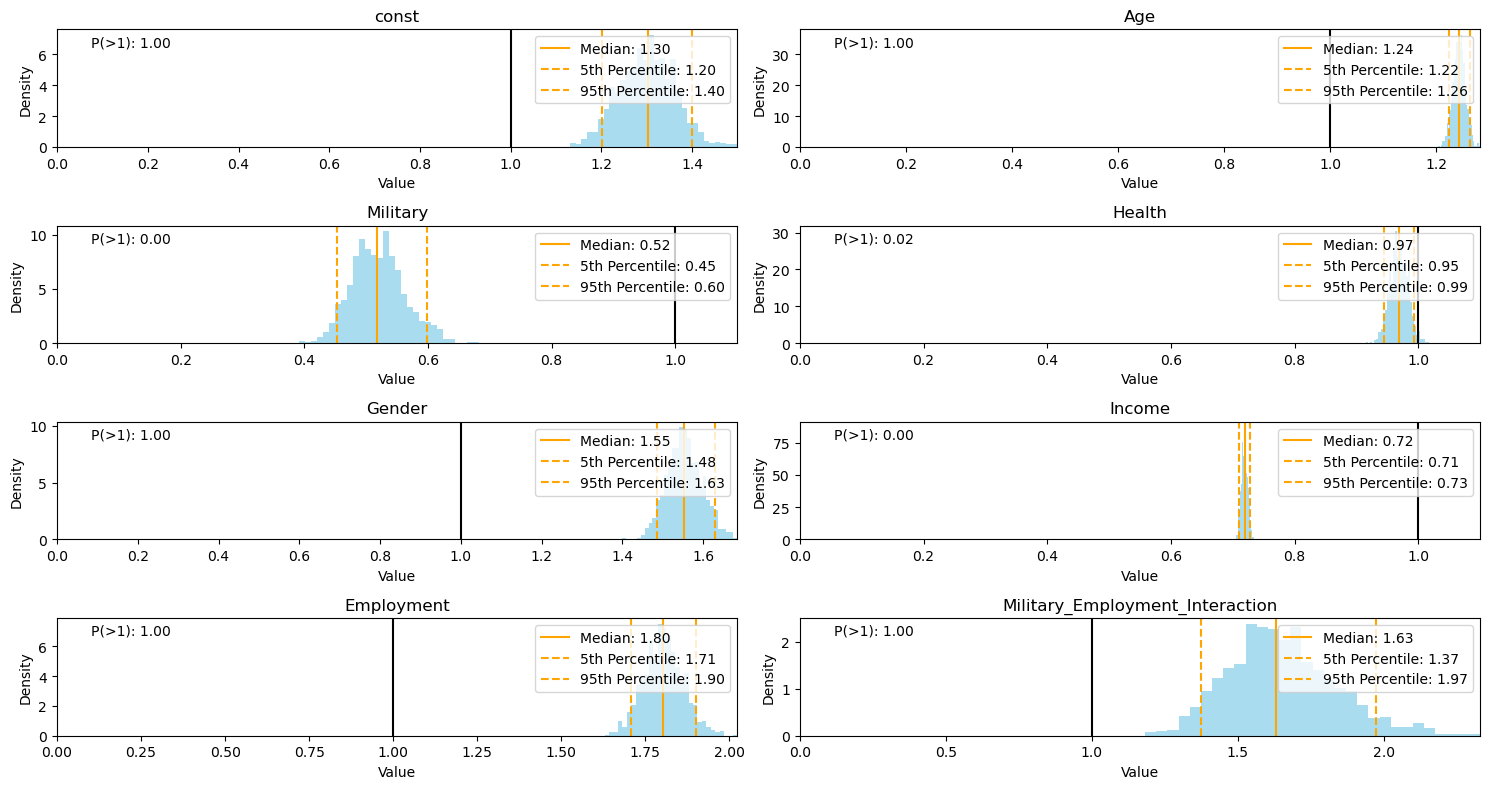

In [215]:
# Calculate statistics for each coefficient
medians = np.median(simulated_betas_odds, axis=0)
lower_quantiles = np.percentile(simulated_betas_odds, 5, axis=0)
upper_quantiles = np.percentile(simulated_betas_odds, 95, axis=0)
prob_positive = np.mean(simulated_betas_odds > 1, axis=0)

# Plot names 
col_names = X_with_intercept.columns

# Plot histograms of each coefficient
num_rows = (simulated_betas.shape[1] + 1) // 2  # Adjusted number of rows
fig, axs = plt.subplots(num_rows, 2, figsize=(15, 8))
axs = axs.flatten()

for i in range(simulated_betas.shape[1]):
    ax = axs[i]
    ax.hist(simulated_betas_odds[:, i], bins=30, density=True, alpha=0.7, color='skyblue')

    # Add vertical lines for 0
    ax.axvline(1, color='black', linestyle='-')
    
    # Add vertical lines for median and 90% interval
    ax.axvline(medians[i], color='orange', linestyle='-', label=f'Median: {medians[i]:.2f}')
    ax.axvline(lower_quantiles[i], color='orange', linestyle='--', label=f'5th Percentile: {lower_quantiles[i]:.2f}')
    ax.axvline(upper_quantiles[i], color='orange', linestyle='--', label=f'95th Percentile: {upper_quantiles[i]:.2f}')
    
    # Add text annotation for probability above 1
    ax.text(0.05, 0.95, f'P(>1): {prob_positive[i]:.2f}', transform=ax.transAxes, verticalalignment='top', fontsize=10)
    
    ax.set_title(f'{ col_names[i]}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend(loc='upper right')

    # Set x-axis limit to ensure it includes 1 and starts at 0
    ax.set_xlim(left=0, right=max(1.1,abs(simulated_betas_odds[:, i]).max())) 
    
# Hide empty subplot
if simulated_betas.shape[1] % 2 != 0:
    axs[-1].axis('off')
    
plt.tight_layout()
plt.show()

#### d) Interpret every coefficient in the model. Pay attention to `statistical significance`, and be clear about what the baseline profile over which the effects are calculated is.

#### Answer: 

...


In [216]:
# Finally, let's get the AIC of the model just to compare with what we did before. 
# Is the added complexity justified ? 
aic = model.aic
print("AIC:", aic)

AIC: 31252.91376055765


## A final note: 

I suspect you will emerge out of this workshop thinking that odds and odds ratios are, at the very least, `tricky`. I agree with you ! Remember you always have the option of using predicted values for your inference, and calculating Relative Risk and Risk Differences between profiles of interests and reference profiles. We will explore this more in the future workshops. 